#### This notebook analyses the heat content and SST responses in the abrupt ACCESS-OM2 experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35107/status,
Dashboard: /proxy/35107/status,Workers: 8
Total threads: 8,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38839,Workers: 8
Dashboard: /proxy/35107/status,Total threads: 8
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:40253,Total threads: 1
Dashboard: /proxy/36201/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:39351,


In [8]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)
# cc.querying.get_experiments(session, all=True)

,experiment,contact,email,created,description,notes,url,root_dir,ncfiles
0,1deg_jra55_ryf_cont,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,24764
1,1deg_jra55_ryf_rcp45warm_x1_spinup500,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,42426
2,1deg_jra55_ryf_rcp45cool_x1_spinup500,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,42426
3,1deg_jra55_ryf_warm_0sat_8dwlw_spinup500,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,21206
4,1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,21206
5,1deg_jra55_ryf_RCPwarm_humid_x1,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,42426
6,1deg_jra55_ryf_RCPwarm_humid_x2,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,42207
7,1deg_jra55_ryf_RCPcool_humid_x1,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,3820
8,1deg_jra55_ryf_RCPcool_humid_x2,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,4010
9,1deg_jra55_ryf_wcwc_step_test1,None,None,None,None,None,None,/scratch/e14/mp2135/access-om2/archive/1deg_jr...,2108


In [10]:
expt = '1deg_jra55_ryf_cont_nokb'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cont_nokb = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_rcp45cool_x1_nokb_spinup200'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cool_nokb = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_rcp45warm_x1_nokb_spinup200'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warm_nokb = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23279915063104 and this is thread id 23275480807168.
Exception closing connection <sqlite3.Connection object at 0x152ba2ccad50>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/b

In [11]:
expt = '1deg_jra55_ryf_cont_kb4'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cont_kb4 = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_rcp45cool_x1_kb4_spinup200'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cool_kb4 = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_rcp45warm_x1_kb4_spinup200'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warm_kb4 = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [21]:
expt = '1deg_jra55_ryf_cont'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cont_kbv = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cool_kbv = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warm_kbv = cc.querying.getvar(expt, var, session)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

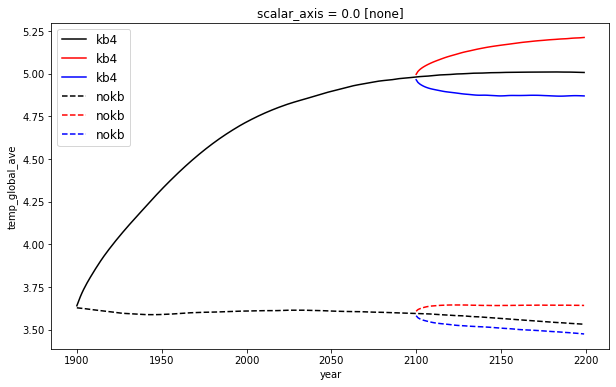

In [14]:
plt.figure(figsize=(10,6))
gat_cont_kb4.plot(label='kb4', color='k')
gat_warm_kb4.plot(label='kb4', color='r')
gat_cool_kb4.plot(label='kb4', color='b')

gat_cont_nokb.plot(label='nokb', linestyle='--', color='k')
gat_warm_nokb.plot(label='nokb', linestyle='--', color='r')
gat_cool_nokb.plot(label='nokb', linestyle='--', color='b')

plt.legend(fontsize=12)

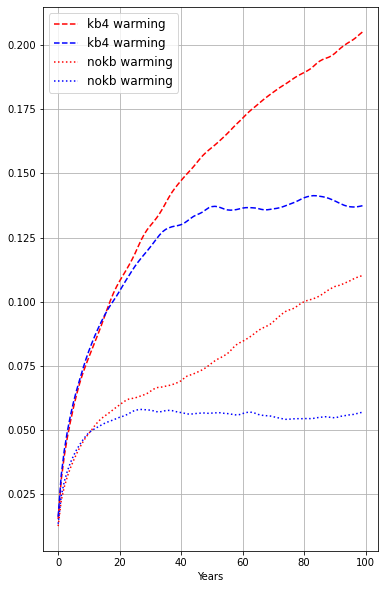

In [29]:
plt.figure(figsize=(6,10))

# (gat_warm_kb4 - gat_cont_kb4).sel(year=slice(None,2150)).plot(label='kb4 warming', color='r')
# (gat_cont_kb4 - gat_cool_kb4).sel(year=slice(None,2150)).plot(label='kb4 cooling', color='b')

# (gat_warm_nokb - gat_cont_nokb).sel(year=slice(None,2150)).plot(label='nokb warming', color='r', linestyle='--')
# (gat_cont_nokb - gat_cool_nokb).sel(year=slice(None,2150)).plot(label='nokb cooling', color='b', linestyle='--')

plt.plot((gat_warm_kb4 - gat_cont_kb4).sel(year=slice(None,2200)).values, color='r', linestyle='--', label='kb4 warming')
plt.plot((gat_cont_kb4 - gat_cool_kb4).sel(year=slice(None,2200)).values, color='b', linestyle='--', label='kb4 warming')

# plt.plot((gat_warm_kbv - gat_cont_kbv).sel(year=slice(2400,2450)).values, color='r', label='kbv warming')
# plt.plot((gat_cont_kbv - gat_cool_kbv).sel(year=slice(2400,2450)).values, color='b', label='kbv cooling')

plt.plot((gat_warm_nokb - gat_cont_nokb).sel(year=slice(None,2200)).values, color='r', linestyle=':', label='nokb warming')
plt.plot((gat_cont_nokb - gat_cool_nokb).sel(year=slice(None,2200)).values, color='b', linestyle=':', label='nokb warming')

plt.legend(fontsize=12)
plt.xlabel('Years')
plt.grid()

In [1]:
expt = '1deg_jra55_ryf_cont_kb4'
var = 'temp'
temp_cont_kb4 = cc.querying.getvar(expt, var, session).mean(dim=('yt_ocean', 'xt_ocean')).groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_cont_nokb'
var = 'temp'
temp_cont_nokb = cc.querying.getvar(expt, var, session).mean(dim=('yt_ocean', 'xt_ocean')).groupby('time.year').mean(dim='time').load()

NameError: name 'cc' is not defined

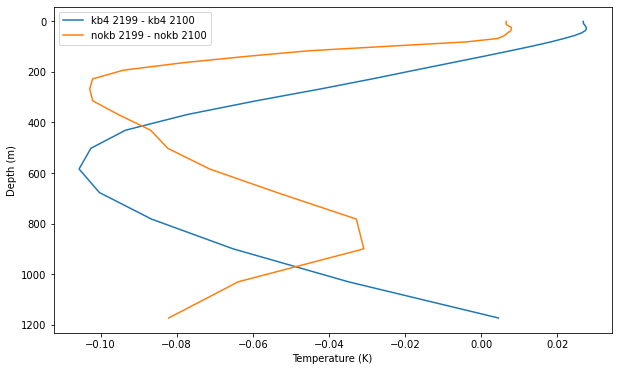

In [20]:
plt.figure(figsize=(10,6))
# plt.plot(temp_cont_kb4.sel(year=2090), temp_cont_kb4.st_ocean, label='kb4')
# plt.plot(temp_cont_nokb.sel(year=2090), temp_cont_nokb.st_ocean, label='nokb')

# plt.plot(temp_cont_kb4.sel(year=2104), temp_cont_kb4.st_ocean, label='kb4 2154')
# plt.plot(temp_cont_kb4.sel(year=2194), temp_cont_kb4.st_ocean, label='kb4 2194')

# plt.plot(temp_cont_nokb.sel(year=2100), temp_cont_kb4.st_ocean, label='nokb 2100')
# plt.plot(temp_cont_nokb.sel(year=2199), temp_cont_kb4.st_ocean, label='nokb 2199')

depth = 1200

plt.plot((temp_cont_kb4.sel(year=2199) - temp_cont_kb4.sel(year=2100)).sel(st_ocean=slice(None, depth)), temp_cont_kb4.st_ocean.sel(st_ocean=slice(None, depth)), label='kb4 2199 - kb4 2100')
plt.plot((temp_cont_nokb.sel(year=2199) - temp_cont_nokb.sel(year=2100)).sel(st_ocean=slice(None, depth)), temp_cont_kb4.st_ocean.sel(st_ocean=slice(None, depth)), label='nokb 2199 - nokb 2100')

plt.gca().invert_yaxis()
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.legend()

In [ ]:
yr_beg = '2400-01-16'
yr_end = '2499-12-31'

expt = '1deg_jra55_ryf_cont'
var = 'temp'
frequency = '1 monthly'
temp_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end).chunk(chunks='auto') 

In [ ]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp'
frequency = '1 monthly'
temp_cool = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp'
frequency = '1 monthly'
temp_warm = cc.querying.getvar(expt, var, session, frequency = frequency, end_time = yr_end).chunk(chunks='auto') 

In [ ]:
# expt = '1deg_jra55_ryf_RCPcool_humid_x2'
# var = 'temp'
# frequency = '1 monthly'
# temp_cool_x2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

# expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
# var = 'temp'
# frequency = '1 monthly'
# temp_warm_x2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

### Global average temperature

In [5]:
yr_beg = '2400-02-01'
yr_end = '2499-12-31'

expt = '1deg_jra55_ryf_cont'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto') 

# [:-1] removes the snapshot at 2500-01-01 for annual avergae purposes

In [6]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cool = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warm = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

In [7]:
# expt = '1deg_jra55_ryf_RCPcool_humid_x2'
# var = 'temp_global_ave'
# frequency = '1 daily'
# gat_cool_x2 = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

# expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
# var = 'temp_global_ave'
# frequency = '1 daily'
# gat_warm_x2 = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

In [8]:
gat_cont = gat_cont.groupby('time.year').mean(dim='time').load()
gat_cool = gat_cool.groupby('time.year').mean(dim='time').load()
gat_warm = gat_warm.groupby('time.year').mean(dim='time').load()
# gat_cool_x2 = gat_cool_x2.groupby('time.year').mean(dim='time').load()
# gat_warm_x2 = gat_warm_x2.groupby('time.year').mean(dim='time').load()

#### Plotting globally averaged temperature over time

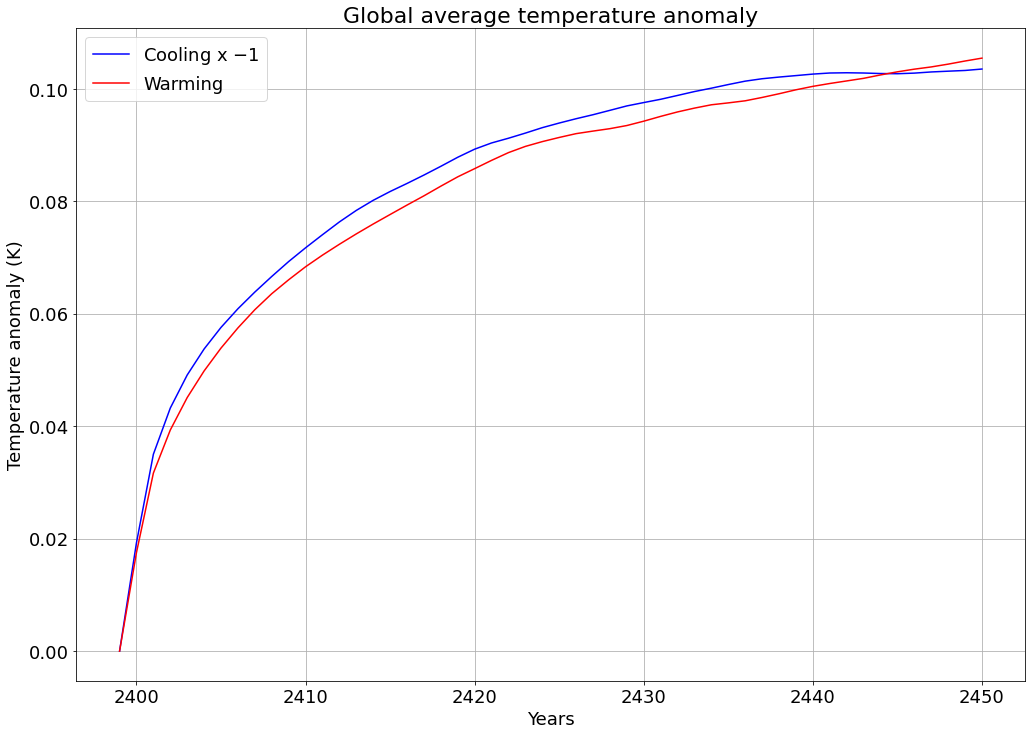

In [9]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
coolx1_anom_plot = xr.concat([zero, gat_cool - gat_cont], dim='year').sel(year=slice(None,2450))
warmx1_anom_plot = xr.concat([zero, gat_warm - gat_cont], dim='year').sel(year=slice(None,2450))

(-1 * coolx1_anom_plot).plot(label='Cooling x $-1$', color = 'b')
warmx1_anom_plot.plot(label='Warming', color = 'r')
plt.title('Global average temperature anomaly', fontsize=22)
plt.ylabel('Temperature anomaly (K)', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Years', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18, loc='best')
plt.grid()
# plt.savefig('ACCESS_gmt_step.jpg')

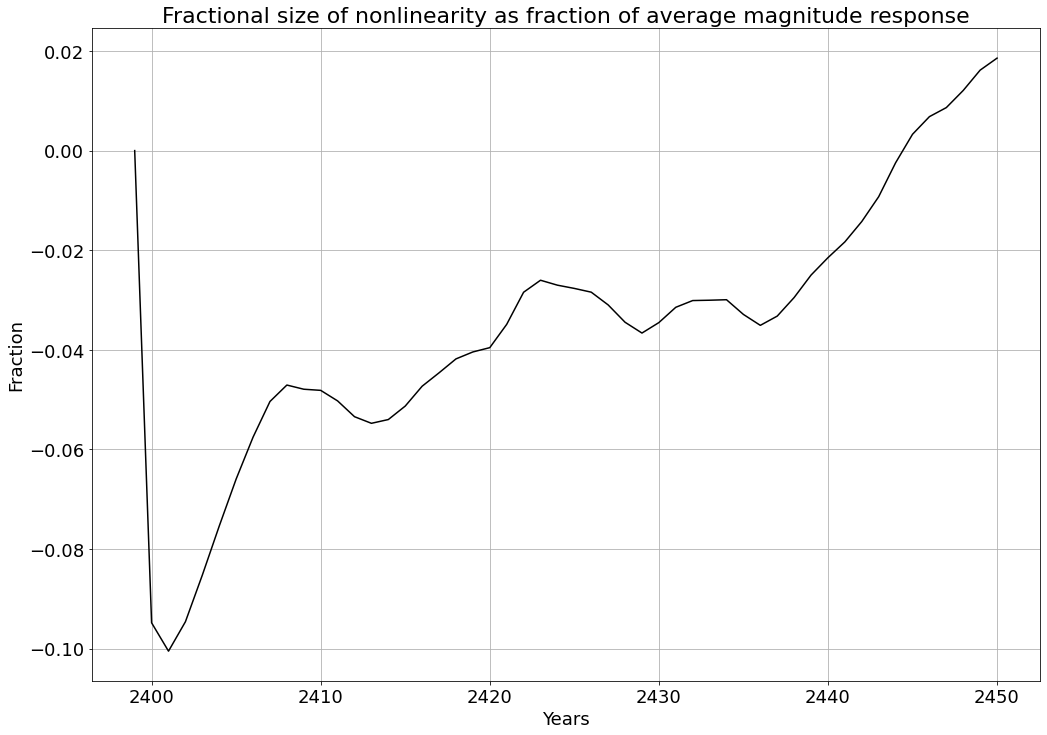

In [31]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
nonlinear_plot = xr.concat([zero, ((gat_warm - gat_cont) + (gat_cool - gat_cont))], dim='year').sel(year=slice(None, 2450)) #  / (((gat_warm - gat_cont) + -1*(gat_cool - gat_cont))/2)
nonlinear_plot = xr.concat([zero, ((gat_warm - gat_cont) + (gat_cool - gat_cont)) / (((gat_warm - gat_cont) + -1*(gat_cool - gat_cont))/2)], dim='year').sel(year=slice(None, 2450))

nonlinear_plot.plot(color = 'k')
plt.title('Fractional size of nonlinearity as fraction of average magnitude response', fontsize=22)
plt.ylabel('Fraction', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Years', fontsize=18)
plt.xticks(fontsize=18)
plt.grid()
# plt.savefig('ACCESS_gmt_step.jpg')

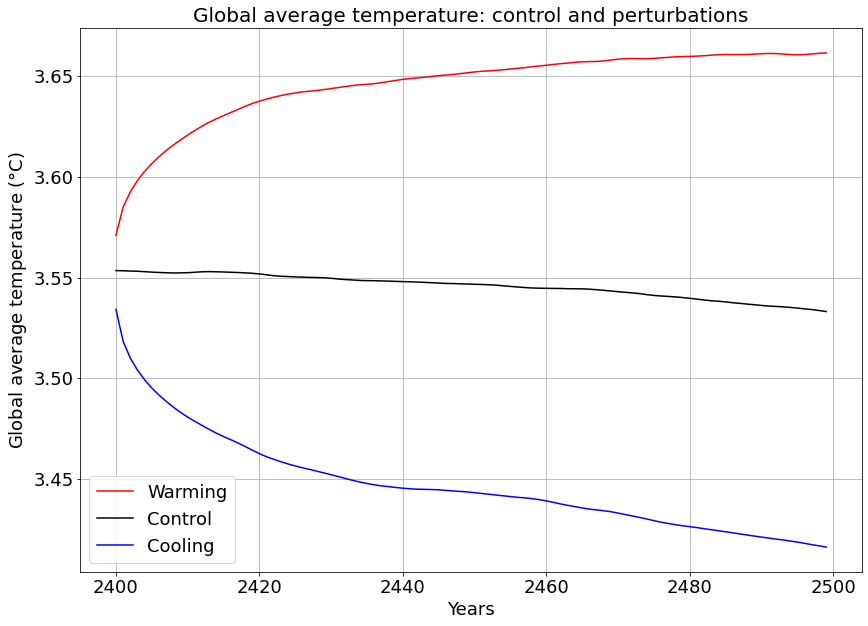

In [39]:
plt.figure(figsize = (14,10))

# zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
# start = xr.DataArray(data=[gat_cont[0].values[0]], dims='year', coords={"year": [2399]})
# coolx1_plot = xr.concat([start, gat_cool], dim='year')
# warmx1_plot = xr.concat([start, gat_warm], dim='year')
# control_plot = xr.concat([start, gat_cont], dim='year')

gat_warm.plot(label='Warming', color = 'r')
gat_cont.plot(color = 'k', label='Control')
gat_cool.plot(label='Cooling', color = 'b')

plt.title('Global average temperature: control and perturbations', fontsize=20)
plt.ylabel('Global average temperature ($\degree$C)', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Years', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid()
# plt.savefig('ch2_temp_drift.jpg', bbox_inches='tight', dpi=100)

### Calculate SST

In [30]:
# SST
yr_beg = '2401-01-01' # I'm not sure why but this year makes the SST start at 2400-01-02, which I want.
expt = '1deg_jra55_ryf_cont'
var = 'temp_surface_ave'
SST_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg)[:-1].groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [31]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_surface_ave'
SST_RCPcool_humid_x1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_surface_ave'
SST_RCPwarm_humid_x1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [32]:
expt = '1deg_jra55_ryf_rcp45cool_x1_nokb_spinup200'
var = 'temp_surface_ave'
SST_cool_nokb = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

expt = '1deg_jra55_ryf_rcp45warm_x1_nokb_spinup200'
var = 'temp_surface_ave'
SST_warm_nokb = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [33]:
expt = '1deg_jra55_ryf_rcp45cool_x1_kb4_spinup200'
var = 'temp_surface_ave'
SST_cool_kb4 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

expt = '1deg_jra55_ryf_rcp45warm_x1_kb4_spinup200'
var = 'temp_surface_ave'
SST_warm_kb4 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [12]:
# expt = '1deg_jra55_ryf_RCPcool_humid_x2'
# var = 'temp_surface_ave'
# SST_RCPcool_humid_x2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

# expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
# var = 'temp_surface_ave'
# SST_RCPwarm_humid_x2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [34]:
SST_cont = SST_cont.load()
SST_RCPcool_humid_x1 = SST_RCPcool_humid_x1.load()
SST_RCPwarm_humid_x1 = SST_RCPwarm_humid_x1.load()
SST_cool_kb4 = SST_cool_kb4.load()
SST_warm_kb4 = SST_warm_kb4.load()
SST_cool_nokb = SST_cool_nokb.load()
SST_warm_nokb = SST_warm_nokb.load()
# SST_RCPcool_humid_x2 = SST_RCPcool_humid_x2.load()
# SST_RCPwarm_humid_x2 = SST_RCPwarm_humid_x2.load()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [35]:
expt = '1deg_jra55_ryf_cont_nokb'
var = 'temp_surface_ave'
SST_cont_nokb = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time').load()

expt = '1deg_jra55_ryf_cont_kb4'
var = 'temp_surface_ave'
SST_cont_kb4 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time').load()

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

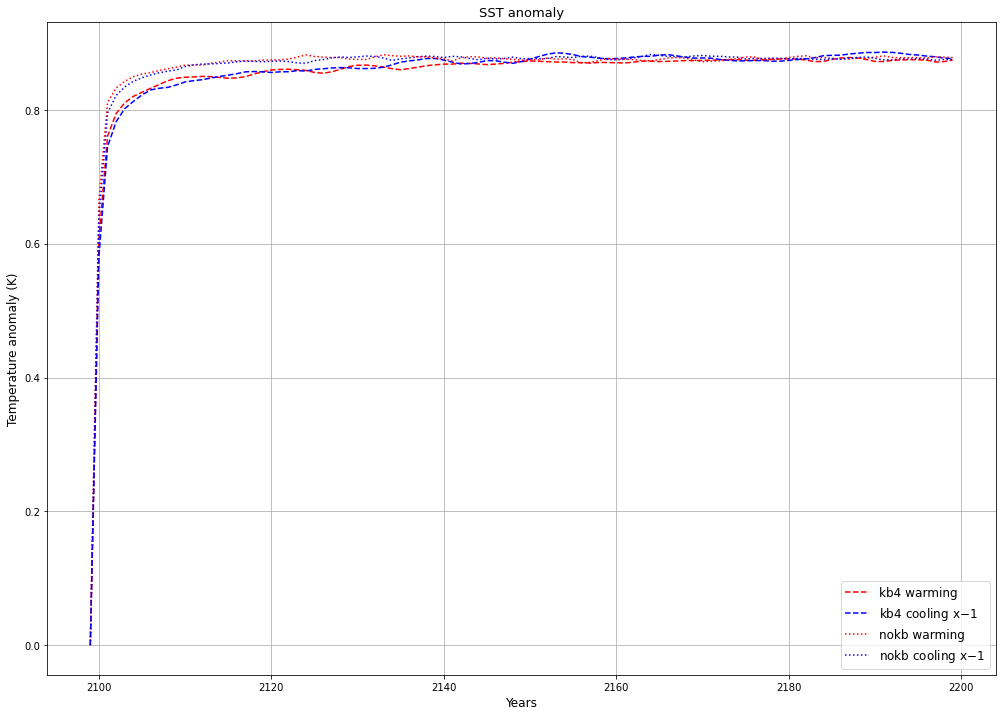

In [37]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

# RCPcool_humid_x1_anom_plot = xr.concat([zero, SST_RCPcool_humid_x1[:,0] - SST_cont[:,0]], dim='year')
# RCPwarm_humid_x1_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x1[:,0] - SST_cont[:,0]], dim='year')
# # RCPcool_humid_x2_anom_plot = xr.concat([zero, SST_RCPcool_humid_x2[:,0] - SST_cont[:,0]], dim='year')
# # RCPwarm_humid_x2_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x2[:,0] - SST_cont[:,0]], dim='year')

# # (0.5 * RCPwarm_humid_x2_anom_plot).plot(label='Double warming x$0.5$', color = 'r', linestyle = '--')
# RCPwarm_humid_x1_anom_plot.plot(label='kbv warming', color = 'r')
# (- 1 * RCPcool_humid_x1_anom_plot).plot(label='kbv cooling x$-1$', color = 'b')
# (- 0.5 * RCPcool_humid_x2_anom_plot).plot(label='Double cooling x$-0.5$', color = 'b', linestyle = '--')

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2099]})

SST_cool_kb4_plot = xr.concat([zero, SST_cool_kb4[:,0] - SST_cont_kb4[:,0]], dim='year')
SST_warm_kb4_plot = xr.concat([zero, SST_warm_kb4[:,0] - SST_cont_kb4[:,0]], dim='year')
SST_warm_kb4_plot.plot(label='kb4 warming', color = 'r', linestyle='--')
(- 1 * SST_cool_kb4_plot).plot(label='kb4 cooling x$-1$', color = 'b', linestyle='--')

SST_cool_nokb_plot = xr.concat([zero, SST_cool_nokb[:,0] - SST_cont_nokb[:,0]], dim='year')
SST_warm_nokb_plot = xr.concat([zero, SST_warm_nokb[:,0] - SST_cont_nokb[:,0]], dim='year')
SST_warm_nokb_plot.plot(label='nokb warming', color = 'r', linestyle=':')
(- 1 * SST_cool_nokb_plot).plot(label='nokb cooling x$-1$', color = 'b', linestyle=':')

plt.title('SST anomaly', fontsize=13)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('SST_good_perturbation.jpg')

### Plot both SST and GAT

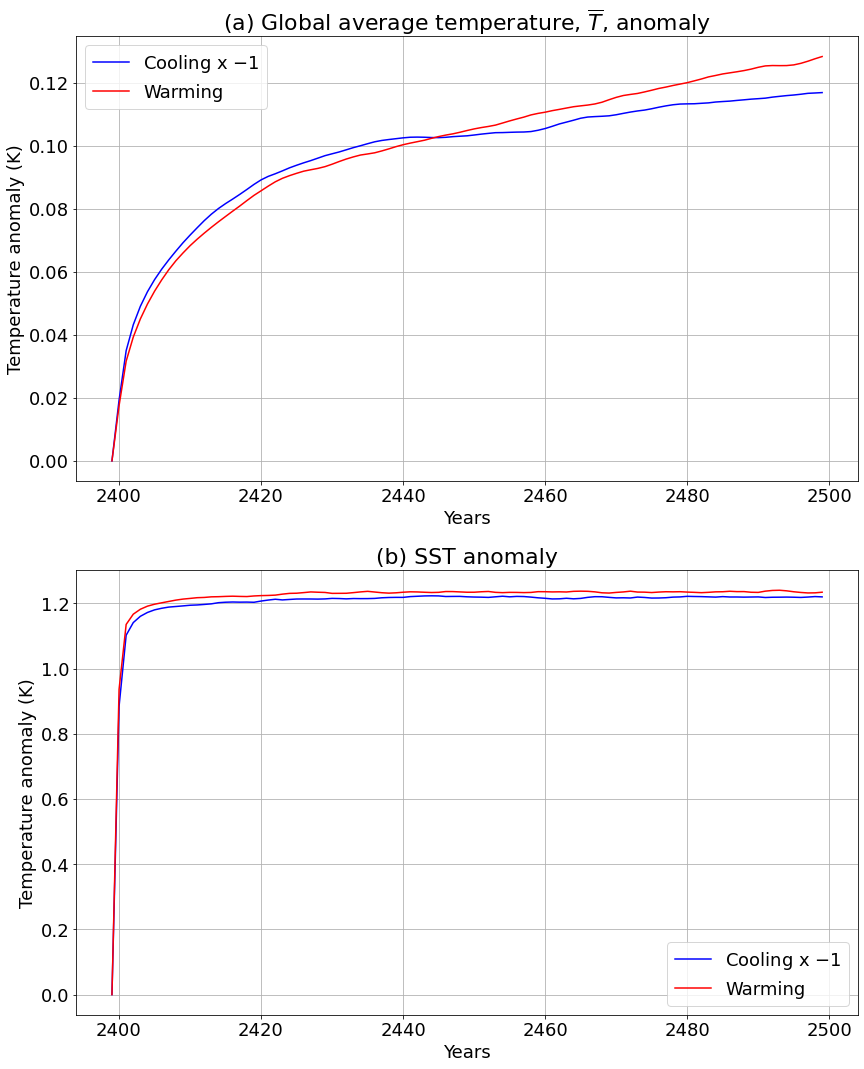

In [16]:
ncols = 1
nrows = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14,18))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

ax = axs[0]
coolx1_anom_plot = xr.concat([zero, gat_cool - gat_cont], dim='year')#.sel(year=slice(None, 2450))
warmx1_anom_plot = xr.concat([zero, gat_warm - gat_cont], dim='year')#.sel(year=slice(None, 2450))
(-1 * coolx1_anom_plot).plot(ax=ax, label='Cooling x $-1$', color='b')
warmx1_anom_plot.plot(ax=ax, label='Warming', color='r')
ax.set_title('(a) Global average temperature, $\overline{T}$, anomaly', fontsize=22)
ax.set_ylabel('Temperature anomaly (K)', fontsize=18)
ax.set_xlabel('Years', fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18, loc='best')
ax.grid()

ax = axs[1]
RCPcool_humid_x1_anom_plot = xr.concat([zero, SST_RCPcool_humid_x1[:,0] - SST_cont[:,0]], dim='year')#.sel(year=slice(None, 2450))
RCPwarm_humid_x1_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x1[:,0] - SST_cont[:,0]], dim='year')#.sel(year=slice(None, 2450))

(-1 * RCPcool_humid_x1_anom_plot).plot(ax=ax, label='Cooling x $-1$', color='b')
RCPwarm_humid_x1_anom_plot.plot(ax=ax, label='Warming', color='r')
ax.set_title('(b) SST anomaly', fontsize=22)
ax.set_ylabel('Temperature anomaly (K)', fontsize=18)
ax.set_xlabel('Years', fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18, loc='best')
ax.grid()

plt.savefig('ch2_gat_sst_anoms.jpg', bbox_inches='tight', dpi=100)

### Calculate horizontally-averaged temperature

In [6]:
def area_weighted_ave(tracer, expt):
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean
    
    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

In [7]:
temp_cool_horizontal_ave_anom = area_weighted_ave(temp_cool - temp_cont, '1deg_jra55_ryf_RCPcool_humid_x1').groupby('time.year').mean(dim='time').load()
temp_warm_horizontal_ave_anom = area_weighted_ave(temp_warm - temp_cont, '1deg_jra55_ryf_RCPwarm_humid_x1').groupby('time.year').mean(dim='time').load()

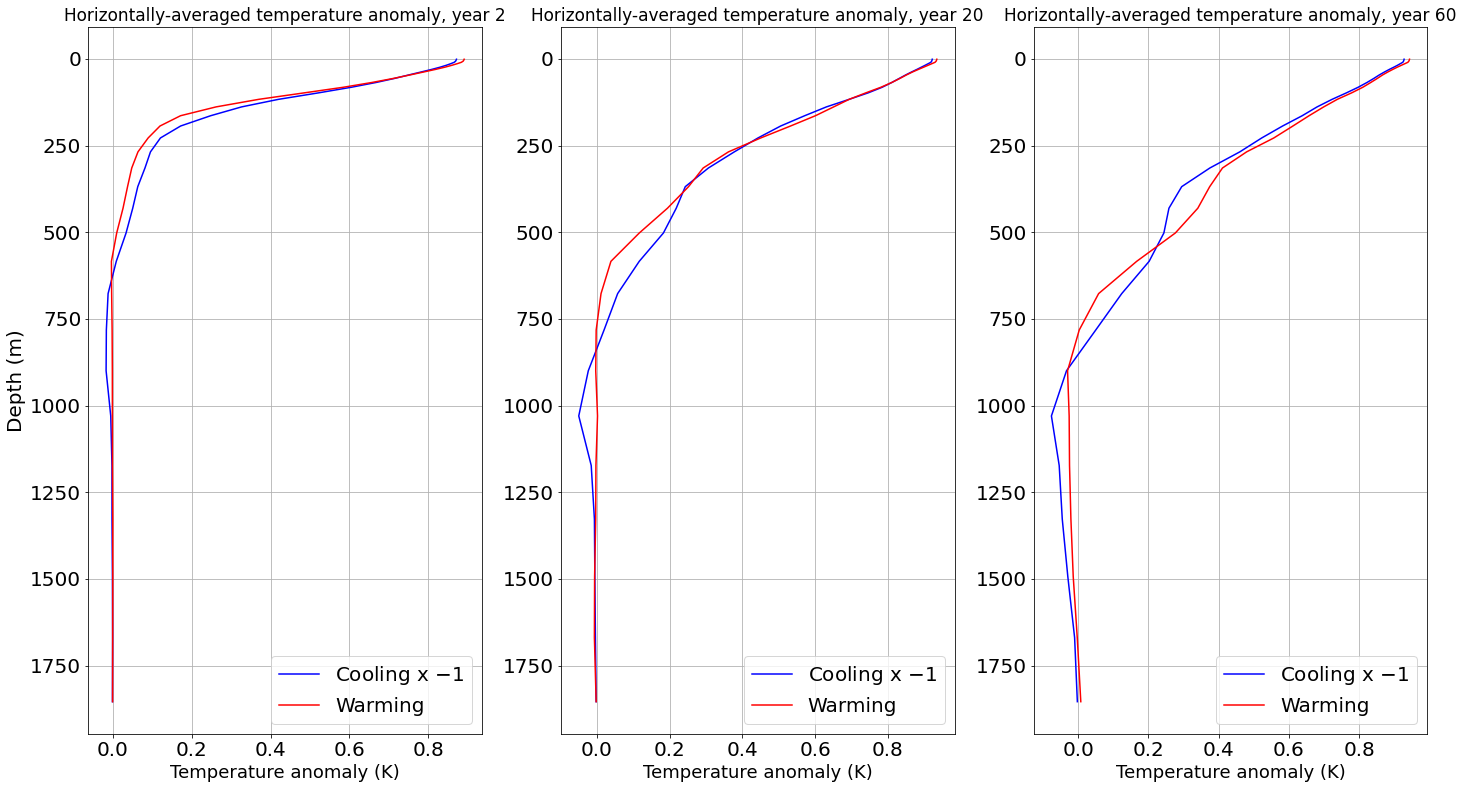

In [27]:
ncols = 3
nrows = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (24,13))

years = 2400 + np.array([2, 20, 60]) 
depth = 2000

for i in range(ncols):
    simulation_year = years[i] - 2400
    axs[i].plot(-1 * temp_cool_horizontal_ave_anom.sel(year=years[i]).sel(st_ocean=slice(None, depth)).values, temp_cool_horizontal_ave_anom.sel(st_ocean=slice(None, depth))['st_ocean'], label='Cooling x $-1$', color = 'b')
    axs[i].plot(temp_warm_horizontal_ave_anom.sel(year=years[i]).sel(st_ocean=slice(None, depth)).values, temp_warm_horizontal_ave_anom.sel(st_ocean=slice(None, depth))['st_ocean'], label='Warming', color = 'r')
    axs[i].set_title(f'Horizontally-averaged temperature anomaly, year {simulation_year}', fontsize=17)
    axs[i].set_xlabel('Temperature anomaly (K)', fontsize=18)
    axs[i].tick_params(labelsize=20)
    axs[i].legend(fontsize=20, loc='lower right')
    axs[i].grid()
    axs[i].invert_yaxis()
axs[0].set_ylabel('Depth (m)', fontsize=20)    

# plt.savefig('ch2_vertical_temperature_anoms.jpg', bbox_inches='tight', dpi=100)

In [92]:
test.sel(st_ocean=240, method='nearest')

<xarray.DataArray ()>
array(0.0312129, dtype=float32)
Coordinates:
    st_ocean  float64 228.2
    year      int64 2402

In [90]:
test = (-1*(temp_cool_horizontal_ave_anom.isel(year=2).sel(st_ocean=slice(None, 600))) - ((temp_warm_horizontal_ave_anom.isel(year=2).sel(st_ocean=slice(None, 600)))))
test[np.argmax(test.values)]

<xarray.DataArray ()>
array(0.07634248, dtype=float32)
Coordinates:
    st_ocean  float64 164.0
    year      int64 2402